In [1]:
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
import os
import geopandas as gpd
import sys
import scipy.stats as stats

/home/x1b3d3ad/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cwd = os.getcwd()
print(cwd)
dataPath = os.path.join(cwd, 'data')
austin_housing = pd.read_csv(os.path.join(dataPath, 'crime-housing-austin-2015.csv'))
zip_codes = pd.read_csv(os.path.join(dataPath, 'AustinZipCodes.csv'))

/home/x1b3d3ad/spring2024/dataScience/cs5830_project2


In [3]:
austin_housing.head()
austin_housing.columns

Index(['Key', 'Council_District', 'Highest_Offense_Desc',
       'Highest_NIBRS_UCR_Offense_Description', 'Report_Date', 'Location',
       'Clearance_Status', 'Clearance_Date', 'District', 'Zip_Code_Crime',
       'Census_Tract', 'X_Coordinate', 'Y_Coordinate', 'Zip_Code_Housing',
       'Populationbelowpovertylevel', 'Medianhouseholdincome',
       'Non-WhiteNon-HispanicorLatino', 'HispanicorLatinoofanyrace',
       'Populationwithdisability', 'Unemployment',
       'Largehouseholds(5+members)',
       'Homesaffordabletopeopleearninglessthan$50000',
       'Rentalsaffordabletopeopleearninglessthan$25000',
       'Rent-restrictedunits', 'HousingChoiceVoucherholders', 'Medianrent',
       'Medianhomevalue', 'Percentageofrentalunitsinpoorcondition',
       'Percentchangeinnumberofhousingunits2000-2012',
       'Ownerunitsaffordabletoaverageretail/serviceworker',
       'Rentalunitsaffordabletoaverageretail/serviceworker',
       'Rentalunitsaffordabletoaverageartist',
       'Ownerunits

In [4]:
# zip_codes.head()
zip_codes.columns
zip_codes.tail()

,#,Zip Code,Location,City,Population,People / Sq. Mile,National Rank
44,45,78617,0,"Austin, Texas","23,020",0,#0
45,46,78660,0,"Austin, Texas","82,260",0,#0
46,47,78653,0,"Austin, Texas","20,120",0,#0
47,48,78652,0,"Austin, Texas","4,400",0,#0
48,49,78712,0,"Austin, Texas","1,000",0,#0


missing zip codes: Empty DataFrame
Columns: [Zip_Code, Total_Crime]
Index: []


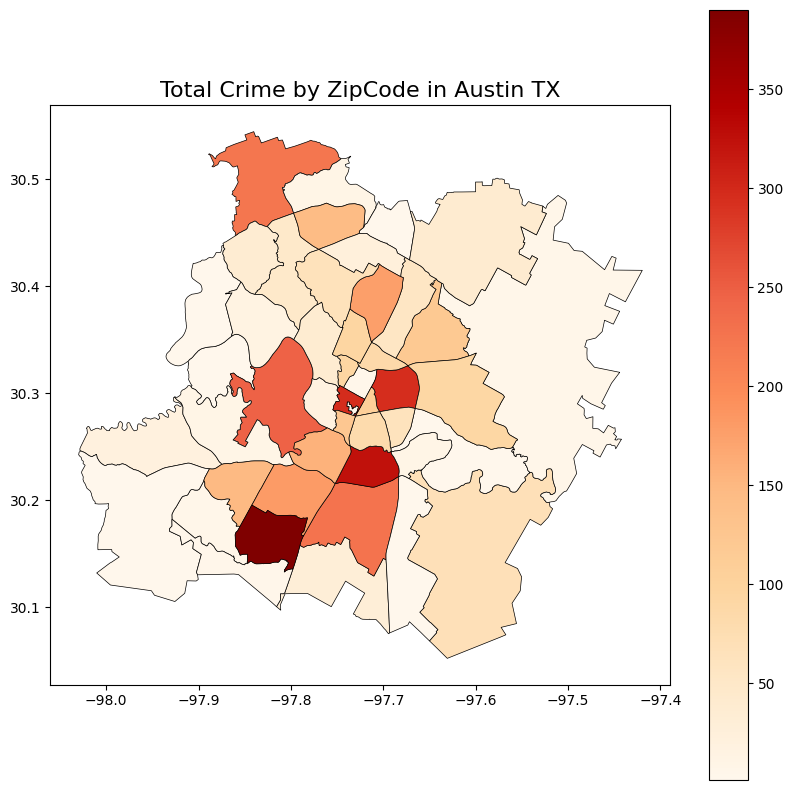

   Zip_Code  crime_per_1000
12    78701       32.166018
13    78754       22.132055
14    78722       16.967793
0     78748       15.377943
34    78742       14.400000
<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 12 to 44
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Zip_Code        47 non-null     object 
 1   crime_per_1000  47 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB
None


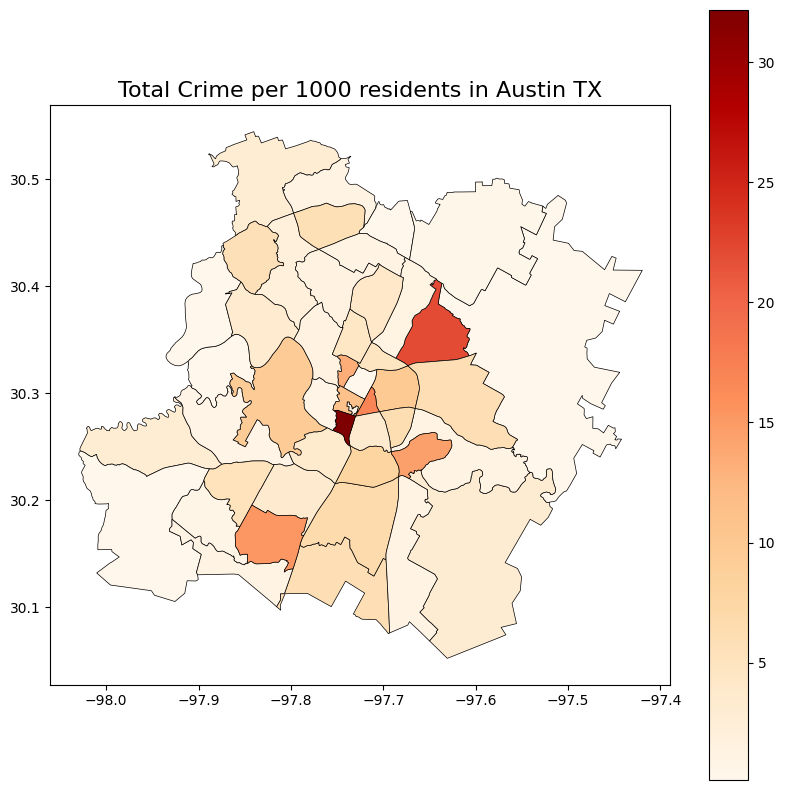

Kruskal-Wallis H-statistic: 46.0
P-value: 0.4722655512253002
The Kruskal-Wallis test is NOT significant. We fail to reject the null hypothesis that the crime rates are the same across all zip codes.
Conclusion: The crime rates are not significantly different across all zip codes.


In [5]:
""" 
Karl's Spatial Analysis 
"""

""" 
Map of Austin TX  
https://openaustin.carto.com/u/oa-admin/tables/austin_area_zip_codes/public?redirected=true 
"""

df = austin_housing.copy()
# Date format: 01-Jan-15.  d=day, b=abbreviated month,y=2-digit year
# df['Report_Date'] = pd.to_datetime(df['Report_Date'], format='%d-%b-%y')

# Aggregate crimes by zip code
crime_zip = df[['Zip_Code_Crime', 'Highest_Offense_Desc']].copy()
crime_zip.rename(columns={'Zip_Code_Crime': 'Zip_Code'}, inplace=True)
crime_zip.dropna(inplace=True)
crime_zip['Zip_Code'] = crime_zip['Zip_Code'].astype('int').astype('str')
crime_zip.groupby(['Zip_Code', 'Highest_Offense_Desc']).count()
crime_zip['Total_Crime'] = crime_zip.groupby(['Zip_Code', 'Highest_Offense_Desc'])['Highest_Offense_Desc'].transform('count')

# Process the crime_zip df to get zip codes and remove duplicates
crime_zip.drop_duplicates(subset=['Zip_Code'], inplace=True)
crime_zip.sort_values(by=['Total_Crime'], ascending=False, inplace=True)
crime_zip.reset_index(drop=True, inplace=True)
crime_zip.drop(columns=['Highest_Offense_Desc'], inplace=True)
crime_zip['Total_Crime'] = crime_zip['Total_Crime'].astype('int')

# Remove zip codes that do not show up in the AustinZipCodes.csv
# display the missing zip codes
missing_zip_codes = crime_zip[~crime_zip['Zip_Code'].isin(zip_codes['Zip Code'].astype('str'))]
crime_zip = crime_zip[crime_zip['Zip_Code'].isin(zip_codes['Zip Code'].astype('str'))]
print(f'missing zip codes: {missing_zip_codes}')

# Load the GeoDataFrame and merge it with crime_zip
austinMap = gpd.read_file(os.path.join(dataPath, 'austin_area_zip_codes.geojson'))
austinMap['zipcode'] = austinMap['zipcode'].astype('str')

# Merge num crimes per zip with the austin map 
austinMapCrimeZip = austinMap.copy()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
austinMapCrimeZip = austinMapCrimeZip.merge(crime_zip, left_on='zipcode', right_on='Zip_Code', how='left')

# Plot the GeoDataFrame
austinMapCrimeZip.plot(ax=ax, figsize=(10, 10), column='Total_Crime', cmap='OrRd', linewidth=0.5, edgecolor='black', legend=True)
ax.set_title('Total Crime by ZipCode in Austin TX', fontsize=16)
plt.show()



"""
Make a new column, titled theft_crime_rate, that is the number of crimes per 1000 people
"""
crime_rate = crime_zip[['Zip_Code', 'Total_Crime']].copy()
population_zip = pd.read_csv(os.path.join(dataPath, 'AustinZipCodes.csv'))
population_zip = population_zip[['Zip Code', 'Population']].copy()
population_zip['Zip Code'] = population_zip['Zip Code'].astype('str')

# Convert population into an int
population_zip['Population'] = population_zip['Population'].str.replace(',', '')
population_zip['Population'] = population_zip['Population'].astype('int')

# Merge population_zip with crime_rate
crime_rate = crime_rate.merge(population_zip, left_on='Zip_Code', right_on='Zip Code', how='left')
crime_rate['crime_per_1000'] = crime_rate['Total_Crime'] / (crime_rate['Population'] / 1000)
crime_rate.sort_values(by=['crime_per_1000'], ascending=False, inplace=True)
crime_rate.drop(columns=['Total_Crime', 'Zip Code', 'Population'], inplace=True)
crime_rate['crime_per_1000'] = crime_rate['crime_per_1000'].fillna(0)
# crime_rate.dropna(inplace=True)
print(crime_rate.head(5))
print(crime_rate.info())

# Plot the population with the geojson map 
# Analysis: How correlated is the number of crimes to the population of a zip code?
austinMapCrimeRate = austinMap.copy()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
austinMapCrimeRate = austinMapCrimeRate.merge(crime_rate, left_on='zipcode', right_on='Zip_Code', how='left')
austinMapCrimeRate.plot(ax=ax, figsize=(10, 10), column='crime_per_1000', 
                        cmap='OrRd', linewidth=0.5, edgecolor='black', 
                        legend=True, )
ax.set_title('Total Crime per 1000 residents in Austin TX', fontsize=16)
plt.show()


# Conduct a t-test on crime rates and zip codes
# Calculate Pearson correlation coefficient and p-value
# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(*[group["crime_per_1000"] for name, group in crime_rate.groupby("Zip_Code")])

# Output results
print(f"Kruskal-Wallis H-statistic: {statistic}")
print(f"P-value: {p_value}")

print("The Kruskal-Wallis test is NOT significant. We fail to reject the null hypothesis that the crime rates are the same across all zip codes.")
print("Conclusion: The crime rates are not significantly different across all zip codes.")


